In [1]:

Variables=['H','LE','fco2','fch4',
           'wind_speed','air_pressure','AirTC_Avg','NR_Wm2_Avg',
           'PPFD_Avg',
           'Table_1','Temp_2_5_1','Temp_2_5_2','Temp_5_1',
           'Temp_5_2','Temp_15_1','Temp_15_2','Ts All Cent',
           'Ts All Rim','VWC_2','VWC_1','Active_Layer_1','24H Rain',
           'wind_dir','ER','Time','DOY',
           'VPD','u*','Wind_Direction','Delta_Table_1',
           'Rolling_Temp_15_1','Delta_air_pressure','Anoxic_Depth','Ratio',
           'Active_Layer_2','Rolling_NR_Wm2_Avg',
              'Rim','Collapse','Polygon','Daytime','nan']
Aliases=['Sensible Heat Flux','Latent Heat Flux','Net Ecosystem Exchange','Net Methante Exchange',
         'Wind Speed','Air Pressure','Air Temperature','Net Radiation',
         'Photon Flux Density',
         'Water Table Depth','Polygon Center Temperature 2.5cm','Polygon Rim Temp. 2.5cm','Polygon Center Temp. 5cm',
         'Polygon Rim Temp. 5cm','Polygon Center Temp. 15cm','Polygon Rim Temp. 15cm','Ts All Cent',
         'Ts All Rim','Volumetric Water Content (Rim)','Center','Thaw Depth','24H Rain','Dir','Ecosystem Respiration','Time','Day of Year',
         'Vapor Pressure Deficit','Friction Velocity','Wind Direction','DW$_{TD}$',
         'Mean T$_{s 15 cm Cnt}$','Dpa','Anoxic Depth','Ratio','Active_Layer_2','Mean Rn',
         'Rim Fraction','Tro Fraction','Cnt Fraction','Daytime','nan']


Abbreviations=['H','LE','NEE','NME',
         'U','Pa','T$_{a}$','Rn',
         'PPFD',
         'W$_{TD}$','T$_{Cnt 2.5}$','T$_{Rim 2.5}$','T$_{Cnt 5}$',
         'T$_{Rim 5}$','T$_{Cnt 15}$','T$_{Rim 15}$','Ts All Cent',
         'Ts All Rim','VWC$_{Rim}$','VWC$_{Cnt}$','TD','24H Rain','Dir','ER','Time','DOY','VPD','u$^*$','Wind Dir','DW$_{TD}$',
         'Mean T$_{s 15 cm Cnt}$','Dpa','Anoxic Depth','Ratio','Active_Layer_2','Mean Rn',
         'F$_{Rim}$','F$_{Tro}$','F$_{Cnt}$','Daytime','nan']

NameDict = {}
for k,n in zip(Variables,Aliases):
    NameDict[k]=n

In [2]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
# from functools import partial
from multiprocessing import Pool
from functools import partial
from sklearn import metrics
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import clear_output
import datetime
import itertools
# from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib as mpl
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.patheffects as pe
%matplotlib notebook

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
import MiscFuncs as MF
importlib.reload(Dense)
importlib.reload(RSTF)
importlib.reload(MF)

# %matplotlib inline
%config IPCompleter.greedy=True

import scipy
from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
# from sklearn.externals 
import joblib
from matplotlib import cm

import matplotlib as mpl
mpl.rcParams["mathtext.default"] = 'regular'

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from ipywidgets import FloatProgress
from IPython.display import display
import os  
import shutil
from keras import backend as K
try:pool.close()
except:pass

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from ipywidgets import FloatProgress, HTML

def t(p,n):
    alpha = 1-p
    df = n-1
    return(stats.t.ppf(alpha,df))

pd.set_option('max_colwidth',200)
MP=True

cwd = os.getcwd()
def Performance(ax,title,target,verbose,lim=None):
    ax.bar(target.level_best['Size'].values,target.level_best['MSE'].values,
            yerr=target.level_best['SE'].values*target.Rule,color='grey',
            alpha = .8,label='Best model at\neach size')
    ax.bar(target.Best['Size'].values,target.Best['MSE'].values,
           yerr=target.Best['SE'].values*target.Rule,
           color='red',alpha = 1,label='Parsimony')
    yaxy = ax.twiny()
    yaxy.bar(target.level_best['Size'].values,target.level_best['MSE'].values,
             yerr=target.level_best['SE'].values*target.Rule,
             color='grey',
             alpha = 0,label=None)
    yaxy.set_xlabel('Number of Factors')
    ax.set_xlabel('Additional Model Input')
    ax.set_title(title,y=1.1,loc='left')
    ax.plot([target.level_best['Size'].min(),target.level_best['Size'].max()],
            [target.Min['MSE'].values[0]+target.Min['SE'].values[0]*target.Rule,
            target.Min['MSE'].values[0]+target.Min['SE'].values[0]*target.Rule])
    plt.sca(ax)
    plt.grid()
    if lim is not None:
        ax.set_xlim(lim)
        yaxy.set_xlim(lim)
    
    i=1
    Labs = []
    for mod in target.level_best.Model.unique():
        print(i,mod)
        if i >1:
            Labs.append([val for val in mod.split('+') if val not in modold.split('+')][0])
        else:
            Labs.append(mod)
        modold=mod
        i+=1
    labels = []
    for lab in Labs:
        labels.append(aliases[lab])
    plt.xticks(target.level_best['Size'],labels,rotation=90)
    if verbose>1:
        print(target.Best)
    
def LevelPerformance(ax,title,target,level=1,Rule=1):
    Data = target.Records.loc[target.Records['Size']==level].sort_values('MSE').reset_index()
    
    if level == 1:
        Data['Name']=Data['Model']
        for val in Data['Model']:
            Data.loc[Data['Model']==val,'Name']=aliases[val]
        Min = Data[Data['MSE']==Data['MSE'].min()]
        Myax = Min['MSE'].values[0]+Min['SE'].values[0]*Rule
        Best = Data[Data['MSE']<=Myax]
        ax.bar(Data['Name'],Data['MSE'].values,
               yerr=Data['SE'].values*target.Rule,
               color='grey',
            alpha = .8,label='Best model at\neach size')
        ax.bar(Best['Name'],Best['MSE'].values,
               yerr=Best['SE'].values*target.Rule,
               color='red',
               alpha = 1,
               label='Parsimony')
        ax.bar(Min['Name'],Min['MSE'].values,
               yerr=Min['SE'].values*target.Rule,
               color='blue',
               alpha = 1,
               label='Parsimony')
    else:
#         alpha = .025
        Min = Data[Data['MSE']==Data['MSE'].min()]
        Myax = Min['MSE'].values[0]+Min['SE'].values[0]*Rule
        Best = Data[Data['MSE']<= Myax]
        ax.bar(Data.index,Data['MSE'].values,
               yerr=Data['SE'].values*target.Rule,
               color='grey',
            alpha = .8,label='Best model at\neach size')
        ax.bar(Best.index,Best['MSE'].values,
               yerr=Best['SE'].values*target.Rule,
               color='red',alpha = 1,label='Parsimony')
        ax.bar(Min.index,Min['MSE'].values,
               yerr=Min['SE'].values*target.Rule,
               color='blue',alpha = 1,label='Parsimony')
    ax.plot([Data.index[0],Data.index[-1]],[Myax,Myax])
    ax.grid()
    print(Data)

def Mapper(AllData,target,name,Fill=False,DarkTarget=None):
    target.Project(Projector = None,
                Model = None)
    if DarkTarget is None:
        target.RST.Data = AllData
    else:
        target.RST.Data = DarkTarget
    print(target.params['target'],target.params['Inputs'],
                       target.params['Spath'])
    if DarkTarget is None:
        target.RST.Scale(target.params['target'],target.params['Inputs'],
                       ScalePath=target.params['Spath'],Project=True)
    else:
        target.RST.Data = DarkTarget
        target.RST.Scale(target.params['target'],target.params['Inputs'],
                   ScalePath=target.params['Spath'],Project=True,fillTarget = DarkTarget)
    target.Map(Fill)
    AllData[name] = target.Data_Map[target.target].values
#     print(AllData[name])
    AllData[name+'_Var_reg'] = target.Data_Map['Var_reg'].values
    AllData[name+'_Var_er'] = target.Data_Map['Var_er'].values
    AllData[name+'_CI'] = target.Data_Map['CI'].values
    AllData[name+'_PI'] = target.Data_Map['PI'].values
    return(AllData)

def PooledVar_interval(Data,Vars,mean,n): 
    Ux = 1/(Data[Vars].count(axis=0).sum())*(Data[Vars].count(axis=0)*Data[Vars].mean(axis=0)).sum()
    P1 = ((Data[Vars].count(axis=0)-1)*Data[Vars].std(axis=0)**2+Data[Vars].count(axis=0)*Data[Vars].mean(axis=0)**2).sum()
    P2 = Data[Vars].count(axis=0).sum()*Ux**2
    VarX = 1/(Data[Vars].count(axis=0)-1).sum()*(P1-P2)
    SigmaX = (VarX)**.5
    return(SigmaX)

class ResultMap:
    def __init__(self,Path,target,Test='N/A',Rule=1,alpha = .025,DataName ='AllData.csv', AltPath=None,Site='FishIsland',FPVars=None):
        self.FPVars = FPVars
        self.target = target        
        self.params = Dense.Params(Path,'Full',self.target,MP)
        self.params['Dpath'] = cwd+'/'+Site+'/'
        self.RST = RSTF.ReadStandardTimeFill(self.params,DataName,FPVars = FPVars)
        if AltPath is None:
            self.Records = pd.read_csv(self.params['Dpath']+'/'+target+'_Runs.csv',delimiter = ',',header = 0,index_col=[0])
            self.params['Dpath'] += target+'/'
        else:
            self.Records = pd.read_csv(self.params['Dpath']+'/'+AltPath+'_Runs.csv',delimiter = ',',header = 0,index_col=[0])
            self.params['Dpath'] += AltPath+'/'           
        self.Records['Model_Key']=self.Records['Size'].astype(str)+'_'+self.Records['Nodes'].astype(str)
        self.Records['RMSE']=self.Records['MSE']**.5
        self.Min = self.Records.loc[self.Records['MSE']==self.Records['MSE'].min()]
        self.Best = self.Records.loc[self.Records.index==Rule]
        self.Model_Selection = self.Best['Model'].values[0]
                
    def Project(self,Projector = None,Model = None):
        if Model ==  None:
            self.Model = self.Model_Selection
        else:
            self.Model = Model
        idx = self.Records['Model_Key'].loc[self.Records['Model']==self.Model].values[0]
        self.params['Spath']=(self.params['Dpath']+idx+'/')
        self.params['Inputs'] = self.Model.split('+')
        self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'])
        if Projector != None:
            if Projector['Map'] == None:
                for ip,val in zip(Projector['Assign']['input'],Projector['Assign']['value']):                    
                    self.RST.Data[ip] = val
            else:
                for ip in self.params['Inputs']:
                    self.RST.Data[ip] = self.RST.Data[ip].mean()
                for ip,val in zip(Projector['Map']['input'],Projector['Map']['min'],Projector['Map']['max']):                    
                    self.RST.Data[ip] = val
                
            self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'],Project=True)
            
    def Map(self,Fill=False,Map=True):
        if Fill == True:
            X = self.RST.X_fill
        else:
            X = self.RST.X
        self.params['Sname']='Y_'
        Y_fill = []
        MSE = []
        prog1 = FloatProgress(min=0, max=self.params['K'],description='Running:')
        display(prog1)
        self.Weights=[]
        if __name__ == "__main__":
            pool = Pool(processes=3,maxtasksperchild=75)
            for k,results in enumerate(pool.imap(partial(Dense.Load_Model,X=X,params=self.params),
                                                 range(self.Best['K'].values[0]))):
                prog1.value+=1
                Y = results[0]
                self.Weights.append(results[1])
#                 print(Y)
                Yold = Y+0
                Y = self.RST.YScaled.inverse_transform(Y)
                if Fill == False and Map == False:
                    mse = (metrics.mean_squared_error(self.RST.y,Y))
                    MSE.append(mse)
                Y_fill.append(Y)
            pool.close()
        Y_fill = np.asanyarray(Y_fill).mean(axis=-1)
        Y_fill_bar = Y_fill.mean(axis=0)
        YTru = self.RST.y+0.0
        if Fill == False and Map == False:
            self.MSE = np.asanyarray(MSE)
            self.CI = stats.t.ppf(1-0.025,k)*self.MSE.std()/(k)**.5
        YStandard = joblib.load(self.params['Spath']+"YVar_scaler.save") 
        self.params['Sname']='Var'
        self.params['Loss']='Boot_Loss'
        
        for k in range(0,1):
            results=Dense.Load_Model(k,X=X,params=self.params)
            YVar = results[0]
            YVar = YStandard.inverse_transform(YVar)                    
        X_back = np.squeeze(self.RST.XScaled.inverse_transform(X))
        self.Data_Map = pd.DataFrame(data=X_back,columns=self.params['Inputs'])
        try:
            self.Data_Map['key'] = self.RST.Data['key'].values
        except:
            pass
        self.Data_Map[self.target] = np.squeeze(Y_fill_bar)
        if Map == False:
            self.Data_Map['True'] = YTru
        self.Data_Map['Var_reg'] = 1/(self.params['K']-1)*((Y_fill-Y_fill_bar)**2).sum(axis=0)
        self.Data_Map['Var_er'] = np.squeeze(YVar)
        self.Data_Map['SE'] = self.Data_Map['Var_reg']**.5
        self.T = stats.t.ppf(1-0.025,self.params['K'])
        self.Data_Map['CI']=self.T*self.Data_Map['SE']
        self.Data_Map['PI']=self.T*((self.Data_Map['Var_er']+self.Data_Map['Var_reg'])**.5)
        self.Y_fill = Y_fill
        self.Y_fill_bar = Y_fill_bar
        
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def RecRead(Path):
    AllRes={}
    for f in ['fco2','fch4']:#,'ER']:
        try:
            AllRes[f]={}
            AllRes[f]['Records']=pd.read_csv(Path+f+'_Runs.csv',index_col=0)
            AllRes[f]['Results']=pd.read_csv(Path+f+'_Results.csv',index_col=0)
            AllRes[f]['Derivatives']={}
            AllRes[f]['SSQ'] ={}
            AllRes[f]['X'] = {}
            AllRes[f]['Yhat'] = {}
            AllRes[f]['Ytrue'] = {}
            AllRes[f]['Outputs'] = {}
        except:
            pass
    return(AllRes)

def DerivKeys(Resluts,col): 
    i =0
    Keys = {}
    for f,r in zip(Results.Factors.values,Results[col].values):
        if r > 0:
            Keys[f]=i
            i += 1
    return(Keys)


SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Path = 'C:\\Users\\wesle\\NetworkAnalysis\\'

Site = 'FishIsland_NDVI/'
Site = 'FishIsland/'
Path = Path+Site
AllRes = RecRead(Path = Path) 

Using TensorFlow backend.


In [3]:
for i,F in enumerate(['fco2','fch4']):
    Results = AllRes[F]['Results']
    Labels = ((Results.set_index('Factors')*-1)**.5+1).fillna(0).sum(axis=1).sort_values(ascending=False).index.values
    Records = AllRes[F]['Records']
#     print(Records['Remove'])
    MBE = []
    MBEs = []
    RMSE = []
    RMSEs = []
    r2 = []
    SDev = []

    for I in Records.index:
        
        y = np.load(Path+F+'_Yhat_'+I+'.npy')#.mean(axis=0)
        x = np.load(Path+F+'_Ytrue_'+I+'.npy')#.mean(axis=0)
        K = y.shape[0]
        df = pd.DataFrame(data={'target':y.flatten(),'y':x.flatten()}).dropna()

        mbe = (np.nansum((x-y),axis=1)/((x-y).shape[1]-np.isnan((x-y)).sum(axis=1)))
        MBEs.append(mbe.std())

        rmse = (np.nansum((x-y)**2,axis=1)/((x-y).shape[1]-np.isnan((x-y)).sum(axis=1)))**.5
        RMSEs.append(rmse.std())

        MBE.append((df['y']-df['target']).sum()/df['y'].count())
        SDev.append(np.abs(df['y']-df['target']).sum()/df['y'].count()*2**.5)
        RMSE.append(metrics.mean_squared_error(df['y'],df['target'])**.5)
        r2.append(metrics.r2_score(df['y'],df['target']))

    RMSEs=np.array(RMSEs)
    MBEs=np.array(MBEs)

    df = pd.DataFrame(index = Records.index,data = {'RMSE':RMSE,'SE':RMSEs/(K**.5),'MBE':MBE,'MBESE':MBEs/(K**.5),'R2':r2})
    df['Diff']=df['RMSE'].diff()
    Xlbls = []
    for v in Records.Remove:
        try:
            Xlbls.append(NameDict[v])
        except:
            Xlbls.append('N/A')
            pass
    df = df.iloc[::-1]
    df['Factor']=Xlbls[::-1]
    
    Mn = (df.loc[df['RMSE']==df['RMSE'].min()])
    Mn = (df.loc[df['R2']==df['R2'].max()])
    df['PCT'] = Mn['RMSE'].values[0]/df['RMSE']
    
#     print(Mn[['Factor','R2','RMSE','Diff','MBE']].round(3))
    df['MX']=df['RMSE']+df['SE']
    df['RMSE_MX']=df['MX']-df['RMSE']
    print(df[['Factor','R2','RMSE','SE','MX','RMSE_MX']].round(3)[::-1])
    

      Factor     R2   RMSE     SE     MX  RMSE_MX
21_75    N/A  0.946  0.347  0.003  0.350    0.003
8_75     N/A  0.931  0.393  0.002  0.395    0.002
      Factor     R2   RMSE     SE     MX  RMSE_MX
21_43    N/A  0.743  6.384  0.046  6.430    0.046
8_43     N/A  0.731  6.534  0.047  6.581    0.047


In [4]:
DataName = 'AWS_FI_OLS.csv'
co2_Model_Index = '8_75'
ch4_Model_Index = '8_43'   
fco2 = ResultMap(Path,'fco2',Test='N/A',Rule=co2_Model_Index,DataName=DataName,Site=Site)
fch4 = ResultMap(Path,'fch4',Test='N/A',Rule=ch4_Model_Index,DataName=DataName,Site=Site)
ER = ResultMap(Path,'ER',Test='N/A',Rule=co2_Model_Index,DataName=DataName,Site=Site,AltPath='fco2')
fch4_FP = ResultMap(Path,'fch4',Test='N/A',Rule=ch4_Model_Index,DataName=DataName,Site=Site)
T30 = fco2.RST.Master.copy()
mult = {'fco2':1,#(1e-6 * 12.0107 *1800),
        'ER':1,#(1e-6 * 12.0107 *1800),
        'fch4':1#,#(1e-9 * 12.0107 *1800)
       }

In [5]:
T30 = Mapper(T30,fch4,'NME_est',Fill = False)
T30 = Mapper(T30,fco2,'NEE_est',Fill = False)

T30_Dark = T30.copy()
T30_Dark['PPFD_Avg'] = 0
T30_Dark['Daytime'] = 0


T30_FP = T30.copy()
T30_FP['Polygon'] = T30_FP['Polygon_Obs']
T30_FP['Rim'] = T30_FP['Rim_Obs']

T30 = Mapper(T30,fch4_FP,'NME_est_FP',Fill = False,DarkTarget=T30_FP)
T30 = Mapper(T30,ER,'ER_est',Fill = False,DarkTarget=T30_Dark)

# print(T30)

fch4 ['u*', 'wind_speed', 'NR_Wm2_Avg', 'Table_1', 'Active_Layer_1', 'Temp_15_1', 'Polygon', 'Rim'] C:\Users\wesle\NetworkAnalysis/FishIsland//fch4/8_43/


FloatProgress(value=0.0, description='Running:', max=30.0)

fco2 ['VPD', 'wind_speed', 'PPFD_Avg', 'Active_Layer_1', 'Temp_5_1', 'Temp_5_2', 'Temp_15_2', 'Daytime'] C:\Users\wesle\NetworkAnalysis/FishIsland//fco2/8_75/


FloatProgress(value=0.0, description='Running:', max=30.0)

fch4 ['u*', 'wind_speed', 'NR_Wm2_Avg', 'Table_1', 'Active_Layer_1', 'Temp_15_1', 'Polygon', 'Rim'] C:\Users\wesle\NetworkAnalysis/FishIsland//fch4/8_43/


FloatProgress(value=0.0, description='Running:', max=30.0)

ER ['VPD', 'wind_speed', 'PPFD_Avg', 'Active_Layer_1', 'Temp_5_1', 'Temp_5_2', 'Temp_15_2', 'Daytime'] C:\Users\wesle\NetworkAnalysis/FishIsland//fco2/8_75/


FloatProgress(value=0.0, description='Running:', max=30.0)

In [6]:
mult = {'fco2':1,#(1e-6 * 12.0107 *1800),
        'ER':1,#(1e-6 * 12.0107 *1800),
        'fch4':1#,#(1e-9 * 12.0107 *1800)
       }

for target,name in zip([fch4,fco2,ER,fch4_FP],['NME','NEE','ER','NME_FP']):
    target.cols = []
#     print(target)
#     print(T30.shape, target.Y_fill[0,:].shape)
    for i in range(target.Y_fill.shape[0]):
        T30['Fill']  = target.Y_fill[i,:]
        B = target.RST.Master[target.target].fillna(T30['Fill'])
        T30[name+'_'+str(i)] = target.RST.Master[target.target].fillna(T30['Fill'])#*mult[target.target]
        target.cols.append(name+'_'+str(i))
    T30[name] = T30[target.cols].mean(axis=1)*mult[target.target]
    sp = PooledVar_interval(T30,target.cols,'Mean',n=30)
    target.PooledVar = sp
    target.Mean = T30[name].mean()
print('Done')

Cols=[]
for i in range(target.Y_fill.shape[0]):
    T30['CBal_'+str(i)]=T30['NME_'+str(i)]*mult['fch4']+T30['NEE_'+str(i)]*mult['fco2']
    Cols.append('CBal_'+str(i))
    
T30['CBal'] = T30[Cols].mean(axis=1)

for target,name in zip([fch4,fco2,ER,fch4_FP],['NME_est','NEE_est','ER_est','NME_est_FP']):
    target.cols = []
    for i in range(target.Y_fill.shape[0]):
        T30[name+'_'+str(i)]  = target.Y_fill[i,:]#*mult[target.target]
        target.cols.append(name+'_'+str(i))
    T30[name] = T30[target.cols].mean(axis=1)
    
    sp = PooledVar_interval(T30,[name+'_Var_reg',name+'_Var_er'],'Mean',n=2)
    target.PooledVar = sp
    target.Mean = T30[name].mean()
print('Done')
print(T30['ER_est'].mean())
# print(T30['NEE_est'].mean())
print(T30['ER'].mean())
# print(T30['NEE_est'])

Done
Done
2.5897762775421143
2.5897944825010017


In [16]:
def MI(Data,Vars,JustBetween=False):
#     print()
    Mean = Data[Vars].mean().mean()
    WithinVariance = (Data[Vars].std()**2).mean()
    BetweenVariance = 1/(Data[Vars].shape[1]-1)*((Mean-Data[Vars].mean())**2).mean()
    TotalVariance = WithinVariance + (1+1/Data[Vars].shape[1])*BetweenVariance
    if JustBetween == False:
        return(TotalVariance)
    else:
        return(BetweenVariance)
T30['DOY']=T30.index.dayofyear

Start = 174
End = 256

LongBean_Start = 100
LongBean_End = 300

NDVI_Thresh = 0.388104
NDVI_Thresh = 0.244049
for Y in range(2009,2020):
    Estimates = []
    CIs = []
    SE = []
    IntType = []
    Scale = []
    Samples = []
    Fluxes = []
    Type = []
    Targets = {'NEE':fco2,
               'NME':fch4,
               'NEE_est':fco2,
               'NME_est':fch4,
               'NME_est_FP':fch4_FP,
           'ER_est':ER,
#            'ER':ER
              }
    Temp = T30.loc[(T30['DOY']>=Start)&(T30['DOY']<=End)&(T30.index.year==Y)]
#     Temp = T30.loc[#(T30['NDVI']>NDVI_Thresh)&
#                    (T30['DSSM']>0)&(T30.index.year==Y)]
    Vars = ['NEE_est','NME_est','NME_est_FP']
#     if Y >=2012:
#         Vars.append('NME')
    for Var in Vars:
        target = Targets[Var]
        if Var == 'NEE_est' or Var == 'NME_est' or Var == 'ER_est' or Var == 'NME_est_FP':
            CIPI = 'CI'
            if Var != 'NME_est_FP':
                Fluxes.append(Var.split('_')[0])
            else:
                Fluxes.append('NME_FP')
            
            Type.append('EC Obs.')
            std = MI(Temp,target.cols)**.5*1*mult[target.target]
            Int=Temp[Var+'_CI'].mean()#(std/Temp.shape[0]**.5)*stats.t.ppf(1-.025,Temp[Var].count())
            
        SE.append(std)
        U = Temp[Var].sum()/(Temp.shape[0]/1)#*mult[target.target]
        Estimates.append(U)
        CIs.append(Int)
        Scale.append('Footprint')
        Samples.append(Temp[Var].count())
        IntType.append(CIPI)
    std = MI(Temp,Cols)**.5
    Int = (std/Temp.shape[0]**.5)*stats.t.ppf(1-.025,Temp['CBal'].count())
    Data = {'Flux':Fluxes,'Scale':Scale,'Estimates':Estimates,
            '95% CI/PI':CIs,'SE':SE,'Interval Type':IntType,'N':Samples,'Type':Type}
    if Y == 2009:
        All = pd.DataFrame(data = Data)
#         All[['Flux','Type','Scale','Estimates','SE','95% CI/PI']]
        All['Year'] = Y
    else:
        More = pd.DataFrame(data = Data)
#         More[['Flux','Type','Scale','Estimates','SE','95% CI/PI']]
        More['Year'] = Y
        All = All.append(More)
#         All = All.reset_index()

All = All.reset_index()

All = All.loc[((((All['Flux']=='NME')|(All['Flux']=='NME_FP'))&(All['Year']!=2009))|(All['Flux']=='NEE'))].copy()
# print(All.loc[All['Flux']=='NEE'])
# print(All.index.values)
All

,index,Flux,Scale,Estimates,95% CI/PI,SE,Interval Type,N,Type,Year
0,0,NEE,Footprint,-0.584264,0.529566,0.067627,CI,1992,EC Obs.,2009
3,0,NEE,Footprint,-0.495587,0.426263,0.063141,CI,1992,EC Obs.,2010
4,1,NME,Footprint,26.094005,3.923348,0.000425,CI,1992,EC Obs.,2010
5,2,NME_FP,Footprint,26.094005,3.923348,0.000425,CI,1992,EC Obs.,2010
6,0,NEE,Footprint,-0.486645,0.470658,0.065412,CI,1992,EC Obs.,2011
7,1,NME,Footprint,21.851998,4.660711,0.000490,CI,1992,EC Obs.,2011
8,2,NME_FP,Footprint,21.851998,4.660711,0.000490,CI,1992,EC Obs.,2011
9,0,NEE,Footprint,-0.000424,0.629480,0.070896,CI,1992,EC Obs.,2012
10,1,NME,Footprint,16.894690,6.741811,0.000688,CI,1992,EC Obs.,2012
11,2,NME_FP,Footprint,16.894690,6.741811,0.000688,CI,1992,EC Obs.,2012


<IPython.core.display.Javascript object>


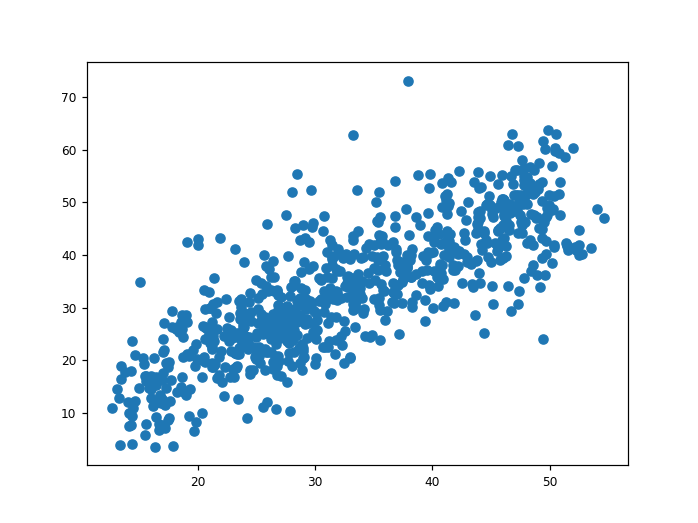

51.25
7.3

count    788.000000
mean       5.552984
std        4.747694
min        0.002332
25%        1.980447
50%        4.356713
75%        8.134530
max       35.213365
Name: NME_Diff, dtype: float64
NR_Wm2_Avg_Diff         7.0
Temp_15_1_Diff         16.6
wind_speed_Diff         1.7
u*_Diff                 3.1
Table_1_Diff           11.0
Active_Layer_1_Diff     1.2
dtype: float64
Daytime
0.0     175
0.5      25
1.0    1137
Name: fco2, dtype: int64


<IPython.core.display.Javascript object>


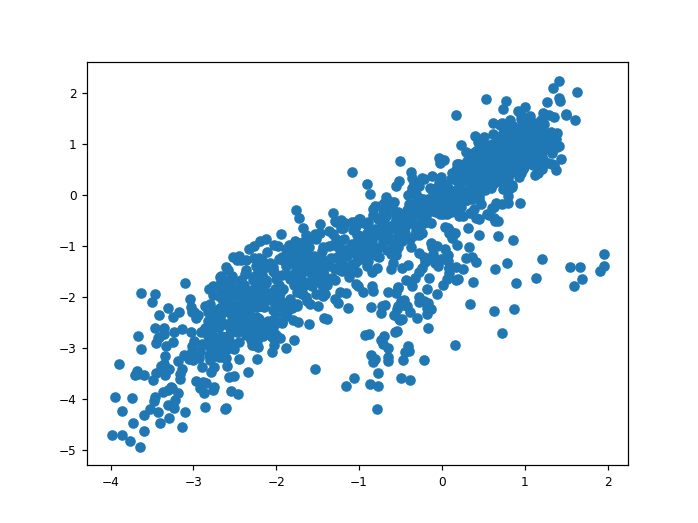

71.1
0.763
count    1337.000000
mean        0.505624
std         0.571852
min         0.000852
25%         0.135645
50%         0.323170
75%         0.649232
max         3.433123
Name: NEE_Diff, dtype: float64
PPFD_Avg_Diff           2.6
VPD_Diff                4.6
Temp_5_1_Diff           8.1
Temp_5_2_Diff          10.2
Temp_15_2_Diff         11.8
Active_Layer_1_Diff     1.4
wind_speed_Diff         1.6
dtype: float64


In [14]:
# Temp = T30.loc[((T30['DOY']>=Start)&(T30['DOY']<=End))].copy()
# print(Temp.resample('D').mean()['NEE_est'].mean(),Temp['Gpp'].mean()/24)
plt.figure()
plt.scatter(T30['NME_est_FP'],T30['fch4'])
DNA=(T30[['NME_est_FP','fch4']].dropna())
print((metrics.r2_score(DNA['NME_est_FP'],DNA['fch4'])*100).round(3))
print((metrics.mean_squared_error(DNA['NME_est_FP'],DNA['fch4'])**.5).round(1))
print()

T30['NME_Diff']=(T30['NME_est_FP']-T30['fch4']).abs()

# L = [V+'_Diff' for V in fco2.Model_Selection.split('+')]

print(T30['NME_Diff'].describe())
print((T30.loc[T30['NME_Diff']>T30['NME_Diff'].quantile(.75),['NR_Wm2_Avg_Diff','Temp_15_1_Diff','wind_speed_Diff'
                                                 ,'u*_Diff','Table_1_Diff',
                                                  'Active_Layer_1_Diff']].abs().mean()/
     (T30.loc[T30['fch4'].isnull()==False,['NR_Wm2_Avg','Temp_15_1','wind_speed',
                                                 'u*','Table_1',
                                                  'Active_Layer_1']].max()-T30.loc[T30['fch4'].isnull()==False,['NR_Wm2_Avg','Temp_15_1','wind_speed',
                                                 'u*','Table_1',
                                                  'Active_Layer_1']].min()).values
     ).round(3)*100)

# plt.figure()
# plt.scatter(T30['NEE_est'],
print(T30.groupby('Daytime').count()['fco2'])

plt.figure()
plt.scatter(T30['NEE_est'],T30['fco2'])
DNA=(T30[['NEE_est','fco2']].dropna())
print((metrics.r2_score(DNA['NEE_est'],DNA['fco2'])*100).round(1))
print((metrics.mean_squared_error(DNA['NEE_est'],DNA['fco2'])**.5).round(3))

T30['NEE_Diff']=(T30['NEE_est']-T30['fco2']).abs()

# L = [V+'_Diff' for V in fco2.Model_Selection.split('+')]

print(T30['NEE_Diff'].describe())
print((T30.loc[T30['NEE_Diff']>T30['NEE_Diff'].quantile(.75),['PPFD_Avg_Diff','VPD_Diff','Temp_5_1_Diff'
                                                 ,'Temp_5_2_Diff','Temp_15_2_Diff',
                                                  'Active_Layer_1_Diff','wind_speed_Diff']].abs().mean()/
     (T30.loc[T30['fco2'].isnull()==False,['PPFD_Avg','VPD','Temp_5_1'
                                                 ,'Temp_5_2','Temp_15_2',
                                                  'Active_Layer_1','wind_speed']].max()-T30.loc[T30['fco2'].isnull()==False,['PPFD_Avg','VPD','Temp_5_1'
                                                 ,'Temp_5_2','Temp_15_2',
                                                  'Active_Layer_1','wind_speed']].min()).values
     ).round(3)*100)


<IPython.core.display.Javascript object>


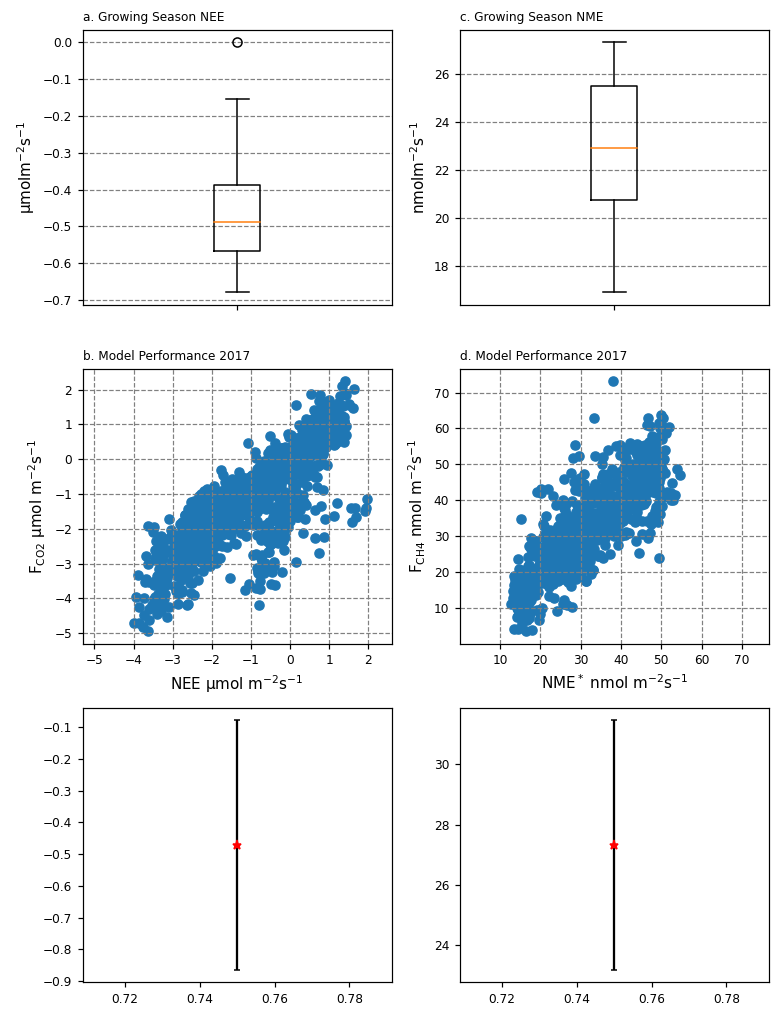

24   -0.471801
Name: Estimates, dtype: float64
24    0.393283
Name: 95% CI/PI, dtype: float64
26    27.323138
Name: Estimates, dtype: float64
26    4.13311
Name: 95% CI/PI, dtype: float64


In [20]:

fig,axes = plt.subplots(3,2,figsize=(18.2*cm_2_in, 23.7*cm_2_in))

# fig,axes = plt.subplots(3,2)

# 95% CI/PI

ax=axes[0,0]
ax.boxplot(All.loc[All['Flux']=='NEE','Estimates'])
ax.set_xticklabels([])
ax.set_ylabel('${\mu}mol m^{-2} s^{-1}$')
ax.set_title('a. Growing Season NEE',loc='left')
ax.set_axisbelow(True)
ax.grid(axis='y',color='gray', linestyle='dashed')
# ax.set_xlim(.75,1.65)


ax=axes[2,0]



ax.errorbar([0.75],All.loc[((All['Year']==2017)&(All['Flux']=='NEE')),'Estimates'],yerr=All.loc[((All['Year']==2017)&(All['Flux']=='NEE')),'95% CI/PI'],marker='*',capsize=2,mfc='r',mec='r',color='k')
# ax.errorbar([1.25],[-0.60],yerr=[0.04],marker='*',capsize=2,mfc='r',mec='r',color='k')
# ax.errorbar([0.5],[-0.39],yerr=[0.39],marker='*',capsize=2,mfc='r',mec='r',color='k')

ax=axes[1,0]
ax.scatter(T30['NEE_est'],T30['fco2'])
# ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
ax.set_xlim(ax.get_ylim()[0],ax.get_ylim()[1])
ax.set_ylabel('$F_{CO2}$ ${\mu}mol$ $m^{-2} s^{-1}$')
ax.set_xlabel('NEE ${\mu}mol$ $m^{-2} s^{-1}$')
ax.set_title('b. Model Performance 2017',loc='left')
# ax.errorbar(x = [-.6],xerr=[-.04],
#             y= All.loc[((All['Year']==2017)&(All['Flux']=='NEE')),'Estimates'],
#             yerr=All.loc[((All['Year']==2017)&(All['Flux']=='NEE')),'95% CI/PI'],
#             marker='*',capsize=2,mfc='r',mec='r',color='k')
# ax.errorbar([1.5],[-.6],yerr=[-0.04],marker='*',capsize=2,mfc='r',mec='r',color='k')
# 
ax=axes[0,1]
ax.boxplot(All.loc[All['Flux']=='NME','Estimates'])
ax.set_xticklabels([])
ax.set_ylabel('$nmol m^{-2} s^{-1}$')
ax.set_title('c. Growing Season NME',loc='left')
ax.set_axisbelow(True)
ax.grid(axis='y',color='gray', linestyle='dashed')



ax=axes[1,1]
ax.scatter(T30['NME_est_FP'],T30['fch4'])
# ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
ax.set_xlim(ax.get_ylim()[0],ax.get_ylim()[1])
ax.set_ylabel('$F_{CH4}$ nmol $m^{-2} s^{-1}$')
ax.set_xlabel('NME$^*$ nmol $m^{-2} s^{-1}$')
ax.set_title('d. Model Performance 2017',loc='left')

ax=axes[2,1]
ax.errorbar([0.75],All.loc[((All['Year']==2017)&(All['Flux']=='NME_FP')),'Estimates'],yerr=All.loc[((All['Year']==2017)&(All['Flux']=='NME_FP')),'95% CI/PI'],marker='*',capsize=2,mfc='r',mec='r',color='k')
# ax.errorbar([1.25],[27.7],yerr=[0.35],marker='*',capsize=2,mfc='r',mec='r',color='k')
# ax.errorbar([0.5],[27.5],yerr=[4.13],marker='*',capsize=2,mfc='r',mec='r',color='k')
# ax.errorbar(x = [27.7],xerr=[0.35],
#             y= All.loc[((All['Year']==2017)&(All['Flux']=='NME')),'Estimates'],
#             yerr=All.loc[((All['Year']==2017)&(All['Flux']=='NME')),'95% CI/PI'],
#             marker='*',capsize=2,mfc='r',mec='r',color='k')

plt.tight_layout()

All.loc[All['Flux']=='NME',['Estimates','Year']].sort_values(by='Estimates')


print(All.loc[((All['Year']==2017)&(All['Flux']=='NEE')),'Estimates'])
print(All.loc[((All['Year']==2017)&(All['Flux']=='NEE')),'95% CI/PI'])
print(All.loc[((All['Year']==2017)&(All['Flux']=='NME_FP')),'Estimates'])
print(All.loc[((All['Year']==2017)&(All['Flux']=='NME_FP')),'95% CI/PI'])

<IPython.core.display.Javascript object>


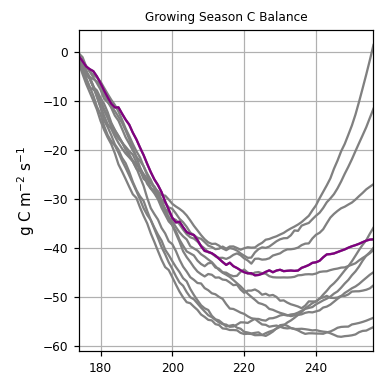

            Max  Max_Date      Total
2019 -58.186588       247 -56.205349
2018 -57.588490       237 -54.298893
2009 -52.346901       236 -47.685051
2014 -53.966965       233 -45.010746
2010 -46.078281       232 -40.437996
2011 -56.148598       216 -40.033123
2017 -45.633678       223 -38.283432
2013 -57.860859       223 -35.907387
2015 -43.243095       222 -27.031063
2016 -42.055367       221 -11.619469
2012 -40.409126       219   1.418667
1.025240788331938


In [12]:
cm_2_in=1/2.54 
fig,ax=plt.subplots(1,figsize=(9*cm_2_in, 9*cm_2_in))
Mx,Pd,Sm,Yz = [],[],[],[]

mult = {'fco2':(1e-6 * 12.0107 *3600),
        'fch4':(1e-9 * 12.0107 *3600)
       }
for y in T30.index.year.unique():
    if y >2008 and y<2020:
        i = y-2009
        Year = T30.loc[((T30.index.year==y)&
                        (T30['DOY']>=Start)&(T30['DOY']<=End))].copy()
        Year['NEE_est'] = Year['NEE_est']*mult['fco2']
        Year['NME_est'] = Year['NME_est']*mult['fch4']
        Year['C']=Year['NEE_est']+Year['NME_est']
        Year=Year[['C']].resample('D').sum().cumsum()
        Mx.append(Year['C'].min())
        Pd.append(Year.loc[Year['C']==Year['C'].min()].index.dayofyear.values[0])
        Sm.append(Year['C'][-1:].values[0])
        ax.plot(Year.index.dayofyear,Year['C'],color='grey')
        Yz.append(y)
        if y == 2017:
            Year_2017 = Year

Cbal = pd.DataFrame(index=Yz,data={'Max':Mx,'Max_Date':Pd,'Total':Sm})
print(Cbal.sort_values(by='Total'))


ax.plot(Year_2017.index.dayofyear,Year_2017['C'],color='Purple',label = str(2017))
ax.grid()
ax.set_title('Growing Season C Balance')
ax.set_ylabel('g C $m^{-2}$ $s^{-1}$')
ax.set_xlim(Start,End)
plt.tight_layout()


plt.savefig('G:\\My Drive\\PhD_Thesis\\Chapter3_Figs/Cbalance.jpg',dpi=600)

print((Cbal['Total'].min()-Cbal['Total'].max())/Cbal['Total'].min())

<IPython.core.display.Javascript object>


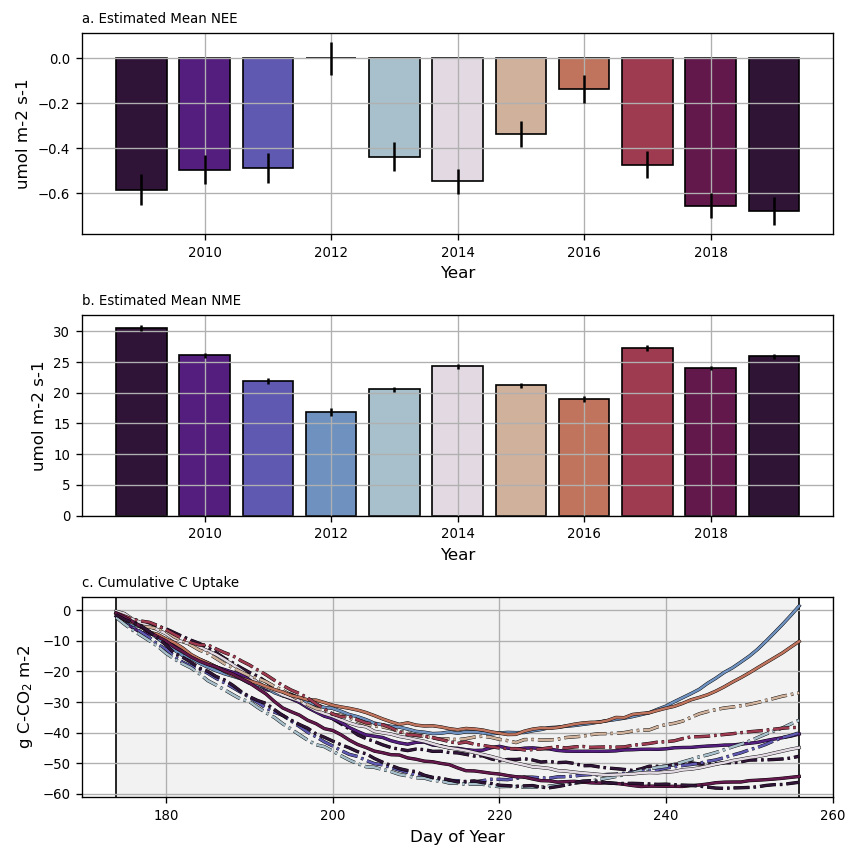

    Estimates  95% CI/PI  Year
0       -0.68       0.06  2019
1       -0.65       0.06  2018
2       -0.58       0.07  2009
3       -0.55       0.06  2014
4       -0.50       0.06  2010
5       -0.49       0.07  2011
6       -0.47       0.06  2017
7       -0.44       0.06  2013
8       -0.34       0.06  2015
9       -0.14       0.06  2016
10      -0.00       0.07  2012
Empty DataFrame
Columns: [Estimates, 95% CI/PI, Year]
Index: []
    Estimates  95% CI/PI  Year
0       16.89       0.70  2012
1       18.97       0.51  2016
2       20.60       0.40  2013
3       21.18       0.37  2015
4       21.85       0.50  2011
5       23.98       0.32  2018
6       24.34       0.40  2014
7       25.90       0.39  2019
8       26.09       0.43  2010
9       27.32       0.46  2017
10      30.61       0.49  2009


In [56]:

fig,ax=plt.subplots(3,figsize=(18.2*cm_2_in, 18.2*cm_2_in))

mult = {'fco2':(1e-6 * 12.0107 *3600),
        'fch4':(1e-9 * 12.0107 *3600)
       }


T30['ER_est_gpp']=-1*(T30['NEE_est'] - T30['ER'])# T30['Gpp']/8/24/mult['fco2']
# print(T30.loc[((T30['DOY']>=Start)&(T30['DOY']<=End)),['ER_est_gpp','ER_est']].mean())

#normalize item number values to colormap
norm = mpl.colors.Normalize(vmin=0, vmax=10)
Colors = []
for i in range(0,11):
    rgba_color = cm.twilight_shifted(norm(i)) 
    Colors.append(rgba_color)
    
Temp = All.loc[All['Flux']=='NEE']
Temp2 = All.loc[All['Flux']=='NEE'].copy()
print(Temp.sort_values(by='Estimates').reset_index()[['Estimates','95% CI/PI','Year']].round(2))
ax[0].bar(Temp['Year'],Temp['Estimates'],yerr=Temp['95% CI/PI'],color=Colors,edgecolor='k')

Temp = All.loc[All['Flux']=='ER']
print(Temp.sort_values(by='Estimates').reset_index()[['Estimates','95% CI/PI','Year']].round(2))

Temp = All.loc[All['Flux']=='NME']
print(Temp.sort_values(by='Estimates').reset_index()[['Estimates','95% CI/PI','Year']].round(2))

ax[1].bar(Temp['Year'],Temp['Estimates'],yerr=Temp['95% CI/PI'],color=Colors,edgecolor='k')
T = []

for y in T30.index.year.unique():
    if y >2008 and y<2020:
        i = y-2009
#         print(y,i)
        Year = T30.loc[((T30.index.year==y)&
                        (T30['DOY']>=Start)&(T30['DOY']<=End))].copy()
#         Year = T30.loc[((T30.index.year==y)&
#                         (T30['snow_cover']<=10)
#                        )].copy()   
        Year['NEE_est'] = Year['NEE_est']*mult['fco2']
        Year['NME_est'] = Year['NME_est']*mult['fch4']
        Year['C']=Year['NEE_est']+Year['NME_est']
        Year=Year[['C']].resample('D').sum().cumsum()
    
        Year['C'] = Year['C']
        if (y % 2) == 0:
            linestyle='-'
        else:            
            linestyle='-.'
            
        ax[2].plot(Year.index.dayofyear,Year['C'],color=Colors[i],linestyle=linestyle,
                   path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()],label = str(y))
        T.append(Year['C'].resample('D').sum().cumsum().min())
        
ax[0].set_title('a. Estimated Mean NEE',loc='left')
ax[0].set_ylabel('umol m-2 s-1')
ax[0].grid()
ax[0].set_xlabel('Year')

ax[1].set_title('b. Estimated Mean NME',loc='left')
ax[1].set_ylabel('umol m-2 s-1')
ax[1].grid()
ax[1].set_xlabel('Year')
ax[2].set_title('c. Cumulative C Uptake',loc='left')
ax[2].set_ylabel('g C-CO$_{2}$ m-2')
ax[2].grid()
ax[2].set_xlabel('Day of Year')
ax[2].axvspan(Start,End,-50,10,facecolor=[.95,.95,.95],edgecolor='k')
plt.tight_layout()
plt.savefig('G:\\My Drive\\PhD_Thesis\\Chapter3_Figs/NEE_Estimates.png')

<IPython.core.display.Javascript object>


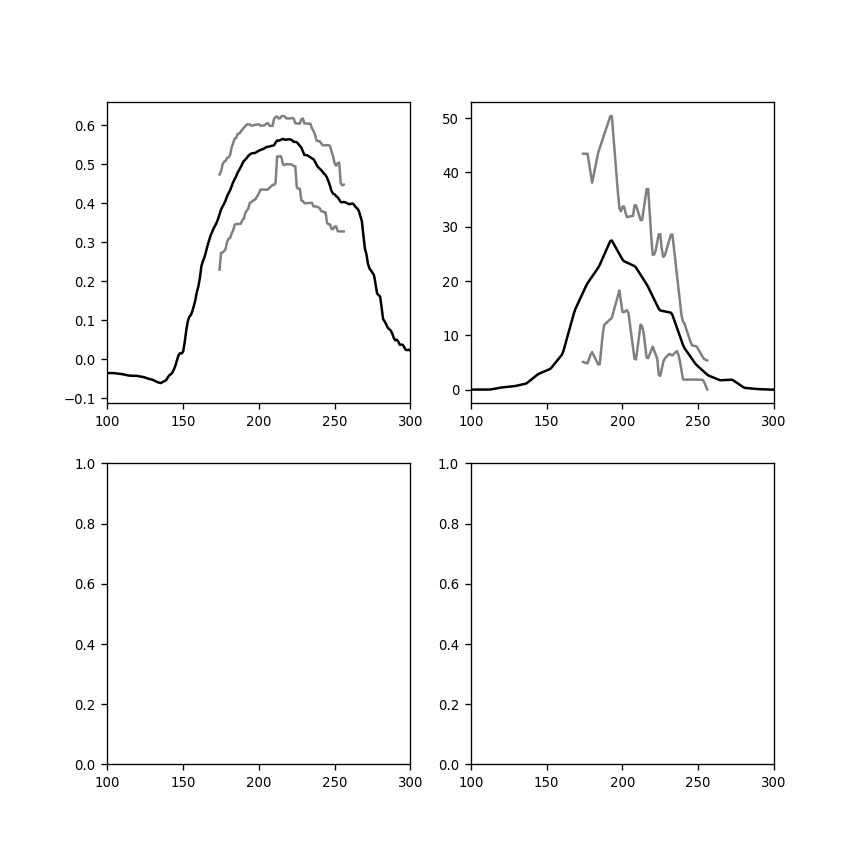

In [89]:

Annual = T30.loc[((T30.index.year==y)&
                        (T30['DOY']>=Start)&(T30['DOY']<=End))].copy()
GS = T30.copy()
GS.loc[((GS.index.year<2009)|(GS.index.year>2019)|
            (GS['DOY']<Start)|(GS['DOY']>End))]=np.nan

GS_Max=GS.groupby(GS.index.dayofyear).max()
GS_Min=GS.groupby(GS.index.dayofyear).min()


fig,axes=plt.subplots(2,2,figsize=(18.2*cm_2_in, 18.2*cm_2_in))

Yearly = T30.groupby(T30.index.dayofyear).mean()

ax=axes[2,0]
ax.plot(GS_Max['ndvi_FI'],color='grey')
ax.plot(GS_Min['ndvi_FI'],color='grey')
ax.plot(Yearly['ndvi_FI'],color='black')

ax=axes[2,1]
ax.plot(GS_Min['GPP_FI'],color='grey')
ax.plot(GS_Max['GPP_FI'],color='grey')
ax.plot(Yearly['GPP_FI'],color='black')

for axe in axes:
    for ax in axe:
        ax.set_xlim(100,300)


# Annual Correlation (DOY 174-256)

- R2 (w/ sign indicating direction of correlation)

### Non-inputs

In [58]:
Non_Inputs=['NEE_est','NME_est','Air_Temp','Rainfall','GPP_FI',
            'ndvi_diff','GPP_diff',
       'GPP_FP', 'ndvi_FI', 'ndvi_FP']
Sat_Data = ['GPP_FI',
       'GPP_FP', 'ndvi_FI', 'ndvi_FP']

# T30[Sat_Data]=BU
BU = T30[Sat_Data].copy()
T30[Sat_Data]=T30[Sat_Data].interpolate()
T30['ndvi_diff']=T30['ndvi_FI'].diff(24)
T30['GPP_diff']=T30['GPP_FI'].diff(24)

V = (T30.loc[((T30['DOY']>=Start)&(T30['DOY']<=End)&
        (T30.index.year>=2009)&(T30.index.year<=2018)),Non_Inputs
       ].resample('Y').mean().corr())[['NEE_est','NME_est']][2:]

V**2*np.sign(V)

,NEE_est,NME_est
Air_Temp,0.467101,-0.215466
Rainfall,0.017339,-0.077617
GPP_FI,0.394390,-0.291267
ndvi_diff,-0.115919,0.033395
GPP_diff,-0.413696,0.250308
GPP_FP,0.364647,-0.247622
ndvi_FI,0.245171,-0.510831
ndvi_FP,0.166661,-0.427780


## Inputs NEE

In [59]:
V = (T30.loc[((T30['DOY']>=Start)&(T30['DOY']<=End)&
        (T30.index.year>=2009)&(T30.index.year<=2018)),
        fco2.Model_Selection.split('+')+['NEE_est']
       ].resample('Y').mean().corr()[['NEE_est']]).round(4).sort_values(by='NEE_est')

V**2*np.sign(V)

,NEE_est
wind_speed,-0.211232
PPFD_Avg,-0.008281
Temp_15_2,0.359880
VPD,0.443156
Daytime,0.520562
Temp_5_2,0.531295
Active_Layer_1,0.608400
Temp_5_1,0.609180
NEE_est,1.000000


## Inputs NME

In [60]:
V = (T30.loc[((T30['DOY']>=Start)&(T30['DOY']<=End)&
        (T30.index.year>=2009)&(T30.index.year<=2018)),
        fch4.Model_Selection.split('+')+['NME_est']
       ].resample('Y').mean().corr()[['NME_est']]).round(4).sort_values(by='NME_est')

V**2*np.sign(V)

,NME_est
Active_Layer_1,-0.936443
Temp_15_1,-0.027159
Polygon,0.000000
Rim,0.000000
NR_Wm2_Avg,0.090481
Table_1,0.173056
wind_speed,0.227052
u*,0.268324
NME_est,1.000000


# 8 Day Correlation (Matches resolution of GPP data)

In [61]:
D8 = T30.resample('8D').mean()

D8 = D8.loc[((D8.index.dayofyear>=Start)&(D8.index.dayofyear<=End)&
        (D8.index.year>=2009)&(D8.index.year<=2018)),Non_Inputs
       ].corr()[['NEE_est','NME_est']][2:]

D8**2*np.sign(D8)

,NEE_est,NME_est
Air_Temp,-0.240094,0.193043
Rainfall,0.009879,-0.006785
GPP_FI,-0.421625,0.318627
ndvi_diff,-0.457243,0.419599
GPP_diff,-0.065317,0.051254
GPP_FP,-0.386257,0.300906
ndvi_FI,-0.011173,0.000228
ndvi_FP,0.001871,-0.013658


## Inputs NEE

In [62]:
D8 = T30.resample('8D').mean()
D8 = D8.loc[((D8.index.dayofyear>=Start)&(D8.index.dayofyear<=End)&
        (D8.index.year>=2009)&(D8.index.year<=2018)),
        fco2.Model_Selection.split('+')+['NEE_est']
       ].resample('8D').mean().corr()[['NEE_est']].round(4).sort_values(by='NEE_est')

D8**2*np.sign(D8)

,NEE_est
Daytime,-0.820655
PPFD_Avg,-0.747360
Temp_5_2,-0.348454
VPD,-0.291708
Temp_5_1,-0.125316
wind_speed,-0.004583
Temp_15_2,0.418092
Active_Layer_1,0.839056
NEE_est,1.000000


## Inputs NME

In [63]:
D8 = T30.resample('8D').mean()
D8 = D8.loc[((D8.index.dayofyear>=Start)&(D8.index.dayofyear<=End)&
        (D8.index.year>=2009)&(D8.index.year<=2018)),
        fch4.Model_Selection.split('+')+['NME_est']
       ].resample('8D').mean().corr()[['NME_est']].round(4).sort_values(by='NME_est')


D8**2*np.sign(D8)

,NME_est
Active_Layer_1,-0.918147
Temp_15_1,-0.368328
Table_1,-0.148687
Polygon,0.000000
Rim,0.000000
wind_speed,0.008911
u*,0.021580
NR_Wm2_Avg,0.658532
NME_est,1.000000


# Daily Correlation

In [64]:
D = T30.loc[((T30['DOY']>=Start)&(T30['DOY']<=End)&
        (T30.index.year>=2009)&(T30.index.year<=2018)),Non_Inputs
       ].resample('D').mean().corr()[['NEE_est','NME_est']][2:]

D**2*np.sign(D)

,NEE_est,NME_est
Air_Temp,-0.103530,0.117817
Rainfall,0.032831,-0.010447
GPP_FI,-0.332358,0.259101
ndvi_diff,-0.193191,0.189356
GPP_diff,-0.042622,0.041145
GPP_FP,-0.308056,0.245320
ndvi_FI,0.001563,-0.012315
ndvi_FP,0.016853,-0.038558


## Inputs NEE

In [65]:
D = T30.resample('D').mean()
D = D.loc[((D.index.dayofyear>=Start)&(D.index.dayofyear<=End)&
        (D.index.year>=2009)&(D.index.year<=2018)),
        fco2.Model_Selection.split('+')+['NEE_est']
       ].resample('D').mean().corr()[['NEE_est']].round(4).sort_values(by='NEE_est')


D**2*np.sign(D)

,NEE_est
Daytime,-0.745114
PPFD_Avg,-0.588442
Temp_5_2,-0.169744
VPD,-0.130972
Temp_5_1,-0.030172
wind_speed,0.001739
Temp_15_2,0.406789
Active_Layer_1,0.718595
NEE_est,1.000000


## Inputs NME

In [66]:
D = T30.resample('D').mean()
D = D.loc[((D.index.dayofyear>=Start)&(D.index.dayofyear<=End)&
        (D.index.year>=2009)&(D.index.year<=2018)),
        fch4.Model_Selection.split('+')+['NME_est']
       ].resample('D').mean().corr()[['NME_est']].round(4).sort_values(by='NME_est')


D**2*np.sign(D)

,NME_est
Active_Layer_1,-0.867133
Temp_15_1,-0.300852
Table_1,-0.124327
Polygon,0.000000
Rim,0.000000
wind_speed,0.000069
u*,0.001537
NR_Wm2_Avg,0.483581
NME_est,1.000000


<IPython.core.display.Javascript object>


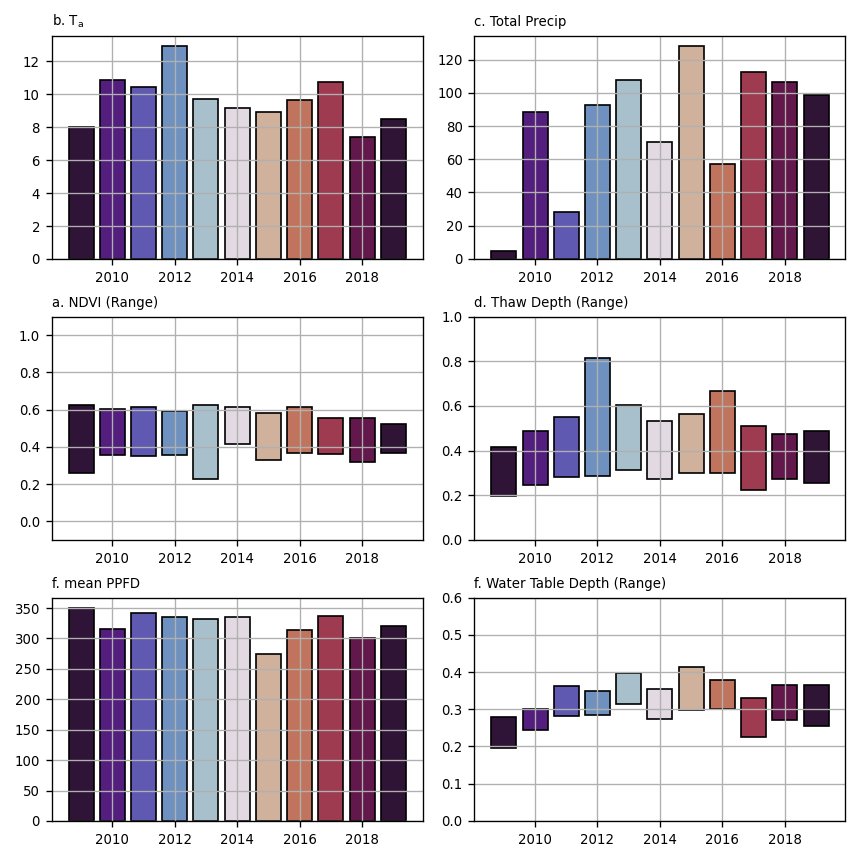

256
0.622817905
0.604305132
0.6137988879999999
0.5925910520000001
0.623495091
0.616643588
0.5816485
0.61669784
0.555812656
0.555650314
0.525446514


In [67]:

# fig,ax=plt.subplots(3,2,figsize=(18.2*cm_2_in, 14.2*cm_2_in))#,sharex=True)
fig,ax=plt.subplots(3,2,figsize=(18.2*cm_2_in, 18.2*cm_2_in))#,sharex=True)
# GS['AirTemp_Avg'].plot()
GSS = []
GSD = []
print(End)
for y in T30.index.year.unique():
    if y > 2008 and y<2020:
        i = y-2009
        Year = T30.loc[((T30.index.year==y)&
                        (T30['DOY']>=Start)&(T30['DOY']<=End))]
        
        YearM = Year.resample('14D').mean()

        if (y % 2) == 0:
            linestyle='-'
        else:            
            linestyle='-.'
            
        print(Year['ndvi_FI'].max())
        ax[0,0].bar(y,Year['Air_Temp'].mean(),color = Colors[i],edgecolor='k')
        ax[0,1].bar(y,Year['Rainfall'].sum(),color = Colors[i],edgecolor='k')
        ax[1,0].bar(y,Year['ndvi_FI'].max()-Year['ndvi_FI'].min(),bottom = Year['ndvi_FI'].min(),
                  color = Colors[i],edgecolor='k')
        ax[1,1].bar(y,Year['Active_Layer_1'].max()-Year['Active_Layer_1'].min(),bottom = Year['Active_Layer_1'].min(),
                  color = Colors[i],edgecolor='k')
        
        
        ax[2,0].bar(y,Year['PPFD_Avg'].mean(),color = Colors[i],edgecolor='k')
        ax[2,1].bar(y,Year['Table_1'].max()-Year['Table_1'].min(),bottom = Year['Active_Layer_1'].min(),
                  color = Colors[i],edgecolor='k')
        
ax[0,0].grid()
ax[1,0].grid()
ax[0,1].grid()
ax[1,1].grid()
ax[2,0].grid()
ax[2,1].grid()

ax[0,0].set_title('b. T$_{a}$',loc='left')
ax[1,0].set_title('a. NDVI (Range)',loc='left')
ax[0,1].set_title('c. Total Precip',loc='left')
ax[1,1].set_title('d. Thaw Depth (Range)',loc='left')
ax[0,1].set_title('c. Total Precip',loc='left')
ax[2,0].set_title('f. mean PPFD',loc='left')
ax[2,1].set_title('f. Water Table Depth (Range)',loc='left')

ax[1,0].set_ylim(-.1,1.1)   
ax[1,1].set_ylim(0,1)   
ax[2,1].set_ylim(0,0.6)     

plt.tight_layout()
plt.savefig('G:\\My Drive\\PhD_Thesis\\Chapter3_Figs/ClimateData.png')

<IPython.core.display.Javascript object>


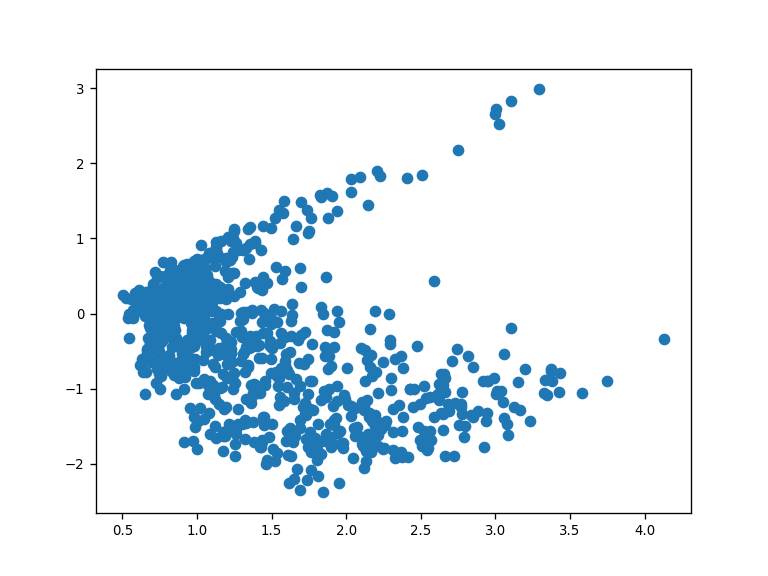

In [68]:
plt.figure()
T = T30.loc[((T30['DOY']>=Start)&(T30['DOY']<=End)&
        (T30.index.year>=2009)&(T30.index.year<=2018))].resample('D').mean()
plt.scatter(T['ER_est'],T['NEE_est'])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


<IPython.core.display.Javascript object>


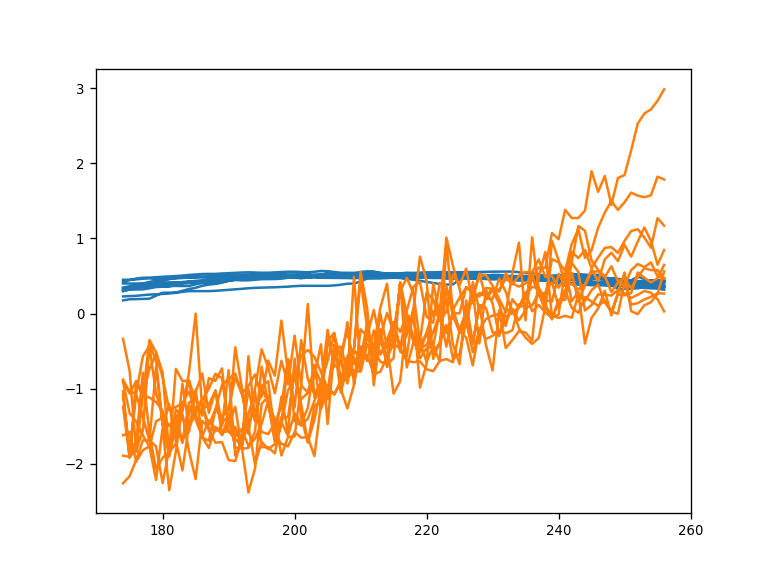

          NEE_est   ndvi_FP
NEE_est  1.000000  0.012844
ndvi_FP  0.012844  1.000000


In [69]:
# plt.figure()

# T30['ST'] = T30['AL']+T30['WTD']
# Temp = T30.groupby(T30.index.dayofyear).mean()
# Temp = Temp.loc[((Temp.index>Start)&(Temp.index<End))]
# # Temp
# plt.plot(Temp['ST'])
# plt.plot(Temp['AL'])
# # plt.plot(-Temp['WTD'])
Temp = T30.loc[((T30['DOY']>=Start)&(T30['DOY']<=End)&
        (T30.index.year>=2009)&(T30.index.year<=2018))]
Temp['DOY']=Temp.index.dayofyear
plt.figure()
plt.plot(Temp['DOY'].resample('D').mean(),Temp['ndvi_FP'].resample('D').mean())
plt.plot(Temp['DOY'].resample('D').mean(),Temp['NEE_est'].resample('D').mean())
# T30.index
print(Temp.groupby('DOY').mean()[['NEE_est','ndvi_FP']].corr()**2)